In [71]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
# Funzioni base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import tqdm

# Font di LaTeX
# from matplotlib import rc

# Scikit-Learn
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.decomposition import PCA, FastICA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
# Funzioni custom
from funzioni import AbsMeanVarDeriv, Whiten,ScatterGroup, MatriceConfusione, indice_gini
from funzioni import tasso_errata_classificazione, grafico_metrica_iperparametro, grafico_metrica_iperparametri
from funzioni.grafici import grafico_importanza_variabili

## Caricamento dei dati

In [73]:
PATH_DATA = './PhonePi/data/'
FIG_PATH = './figure/'
DIR = [os.path.join(PATH_DATA, o) for o in os.listdir(PATH_DATA) 
                    if os.path.isdir(os.path.join(PATH_DATA,o))]
tipo=[(dir.split("/")[-1]).split(".")[0] for dir in DIR]
tipo=[dir.split("-")[0] for dir in tipo]

In [74]:
p = 150 # numero osservazioni per intervallo
nomi_colonna=["user","azione"]
nomi_colonna.extend(["a"+str(i) for i in range(p)])
nomi_colonna
X=pd.DataFrame(columns=nomi_colonna)

for i in tqdm.tqdm(range(len(DIR))):
    data = pd.read_csv(DIR[i] + "/accelerometer.txt", names = ["user", "type", "t", "ax", "ay", "az"]) # lettura dati
    data["t"] = data["t"] - data["t"].iloc[0] # t0 = 0
    data = data[(data["t"] > 7000) & (data["t"] < (data["t"].max()-7000))] # tolti i primi e ultimi 7 secondi
    data.reset_index(drop=True, inplace=True) # ripristinati gli indici da 0 in avanti
    data["a"] = (pd.to_numeric(data["ax"])**2 + pd.to_numeric(data["ay"])**2 + pd.to_numeric(data["az"])**2)**0.5 # accelerazione in modulo
    nome = [data.user[j] for j in range(0,len(data)-p, p)] # intervalli di dt*100ms
    tipologia=[tipo[i]]*len(nome)
    righe=[[nome[j],tipologia[j]] for j in range(len(nome))]
    [righe[j].extend(list(data.a[j*p:(j+1)*p])) for j in range(len(nome))]
    X=pd.concat([X,pd.DataFrame(righe,columns=nomi_colonna)],ignore_index=True) # ignore_index=T per avere indici consecutivi

100%|██████████| 44/44 [00:05<00:00,  9.37it/s]


### Grafici per esempi

100%|██████████| 3/3 [00:01<00:00,  3.00it/s]


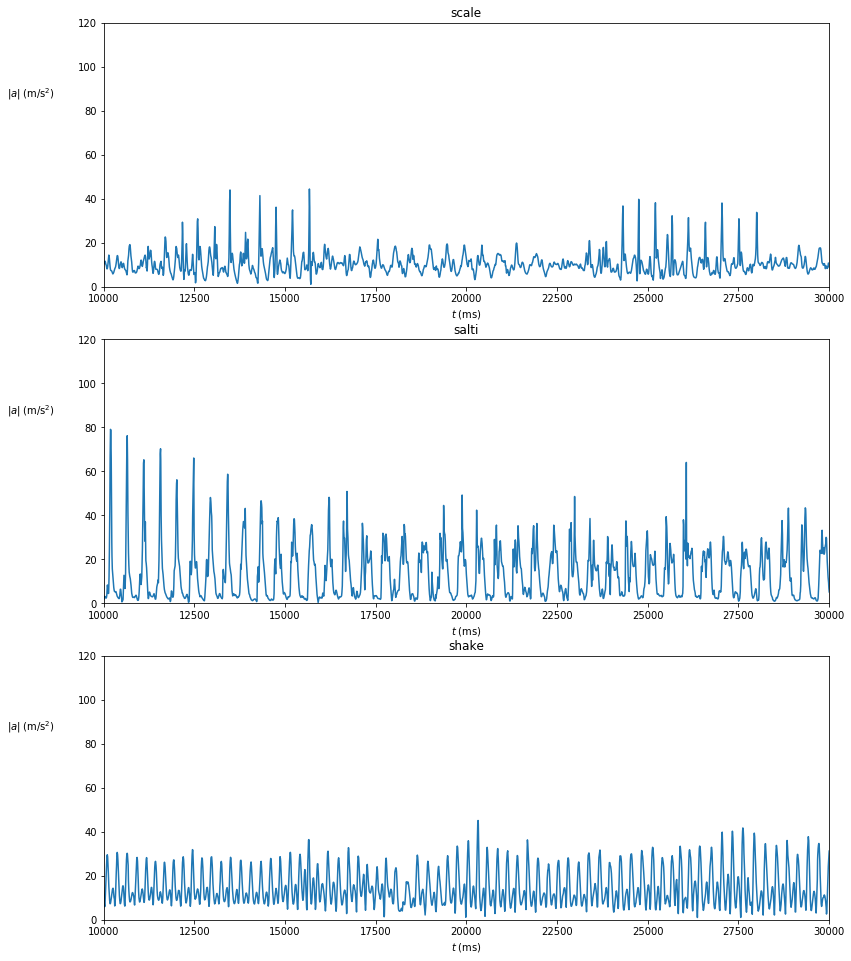

In [75]:
DIRM = ['./PhonePi/data/scale-martina',
        './PhonePi/data/salti-daniele',
        './PhonePi/data/shake-anna']

plt.figure(figsize=(13,5.5*len(DIRM)))
nrow = len(DIRM)
for i in tqdm.tqdm(range(len(DIRM))):
    data = pd.read_csv(DIRM[i] + "/accelerometer.txt", names = ["user", "type", "t", "ax", "ay", "az"])
    data["t"] = data["t"] - data["t"].iloc[0]
    data = data[(data["t"] > 7000) & (data["t"] < (data["t"].max()-7000))]
    data["a"] = (pd.to_numeric(data["ax"])**2 + pd.to_numeric(data["ay"])**2 + pd.to_numeric(data["az"])**2)**0.5 # accelerazione in modulo
    ax = plt.subplot(nrow, 1, i+1, ylim=(0,120), xlim = (10000,30000))
    ax.set_ylabel(r"$\|a\|\;(\mathrm{ m/s}^2)$", rotation=0)
    ax.yaxis.set_label_coords(-0.1,0.7)
    ax.set_xlabel(r"$t \;(\mathrm{ ms})$")
    ax.set_title((DIRM[i].split("/")[-1]).split("-")[0])
    plt.plot(data["t"],data["a"])
    plt.savefig(FIG_PATH+"espl.png", dpi=150)    
plt.show()

## Calcolo delle variabili di riassunto

In [76]:
y = X.azione
X.drop("azione", axis=1, inplace=True)
Xnum = X.drop("user", axis=1)

In [77]:
maxA = Xnum.max(1) # massimo accelerazione
MVDeriv = AbsMeanVarDeriv(Xnum, 10) # variazione media della derivata
Mean = Xnum.mean(axis=1)
Var = Xnum.var(axis=1)
Med = Xnum.median(axis=1)
Min = Xnum.min(axis=1)

In [78]:
espl = pd.concat([maxA, MVDeriv, Mean, Var, Med, Min], axis=1)
espl.columns=["maxA", "MVDeriv", "meanA", "Var", "Med", "Min"]

In [79]:
X.to_pickle("X-2s.pkl")
y.to_pickle("y-2s.pkl")
espl.to_pickle("espl.pkl")

In [80]:
X_train, X_val, y_train, y_val = train_test_split(espl, y, test_size=0.25, random_state=42)

## Analisi esplorativa con `PCA`, `ICA`, `t-SNE`

In [81]:
# Sbiancamento dei dati
esplWh = Whiten().fit_transform(espl)

pca = PCA(n_components=2, random_state=42)
esplPCA = pca.fit_transform(esplWh)

ica = FastICA(n_components=2, random_state=42)
esplICA = ica.fit_transform(esplWh)

tsne = TSNE(n_components=2, random_state=42)
esplTSNE = tsne.fit_transform(esplWh)

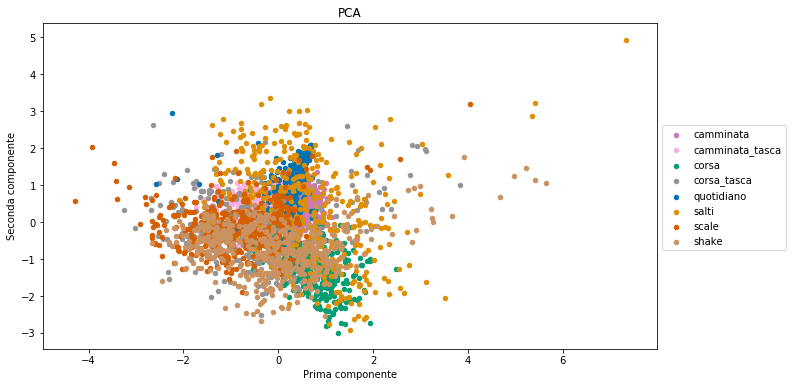

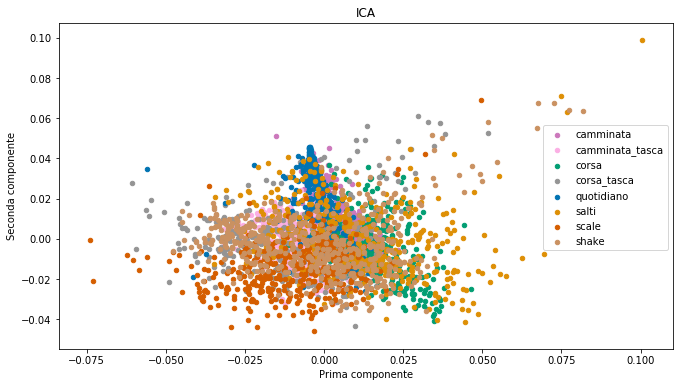

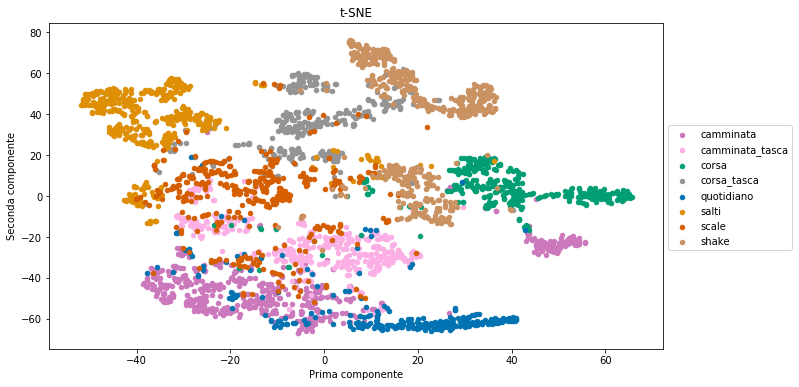

In [82]:
for title,dat in zip(["PCA","ICA","t-SNE"], [esplPCA, esplICA, esplTSNE]):
    fig, ax = ScatterGroup(pd.DataFrame(dat, columns=["Prima componente", "Seconda componente"]),
                       grp=y, palette="colorblind")
    fig.set_figwidth(11)
    fig.set_figheight(6)
    ax.set_title(title)
    plt.legend(bbox_to_anchor=(1,0.7))
    plt.savefig(FIG_PATH+title+".png", bbox_inches="tight", dpi=180)

## Modello baseline multinomiale

/home/dede/anaconda3/envs/msbd/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


LogisticRegression(multi_class="multinomial"): 87.2% di accuratezza


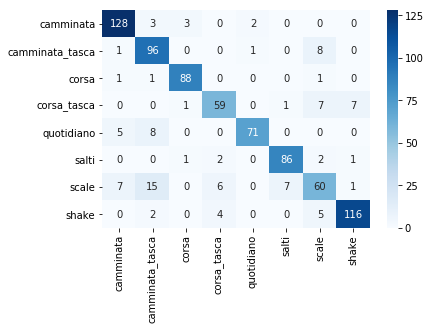

<Figure size 432x288 with 0 Axes>

In [83]:
glmMult = LogisticRegression(penalty="l2", C=float("inf"), random_state=42, multi_class="multinomial",
                             solver="newton-cg", max_iter=1000)
fit = glmMult.fit(X_train, y_train)
y_pred = fit.predict(X_val)

acc_mn = accuracy_score(y_val, y_pred)
print("LogisticRegression(multi_class=\"multinomial\"): {:.1f}% di accuratezza".format(100 * acc_mn))
MatriceConfusione(y_val, y_pred)
plt.savefig(FIG_PATH+"confusionMatrix-Mn.png", dpi=300, bbox_inches="tight")

## Analisi discriminante lineare e quadratica

Accuratezza LDA: 77.1%


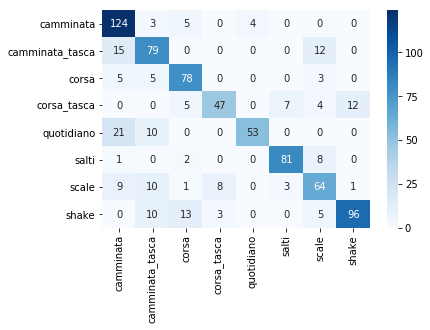

In [84]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda=lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_val)
acc_lda = 100*accuracy_score(y_val, y_pred_lda)
print("Accuratezza LDA: {:.1f}%".format(acc_lda))
MatriceConfusione(y_val, y_pred_qda,nome_immagine=FIG_PATH+"confusionMatrix-LDA")

Accuratezza QDA: 87.9%


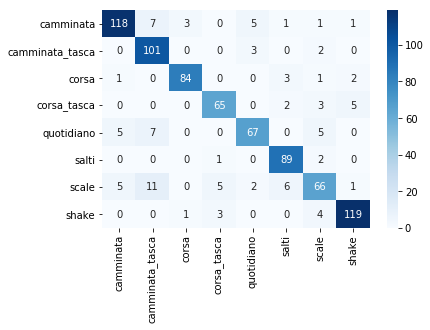

In [100]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred_qda = qda.predict(X_val)
acc_qda = 100*accuracy_score(y_val, y_pred_qda)
print("Accuratezza QDA: {:.1f}%".format(acc_qda))
MatriceConfusione(y_val, y_pred_qda,nome_immagine=FIG_PATH+"confusionMatrix-QDA")

## Da sviluppare, QDA con penalizzazione per gli shake

In [86]:
weights = np.array(y_train.value_counts()/y_train.value_counts().sum())
print(weights)
weights[0] /= 50
weights = weights/weights.sum()
print(weights)

[0.16377171 0.15632754 0.14474773 0.13275434 0.11993383 0.1025641
 0.1025641  0.07733664]
[0.00390163 0.18621424 0.17242059 0.15813431 0.14286277 0.1221723
 0.1221723  0.09212186]


Accuratezza QDA: 84.4%


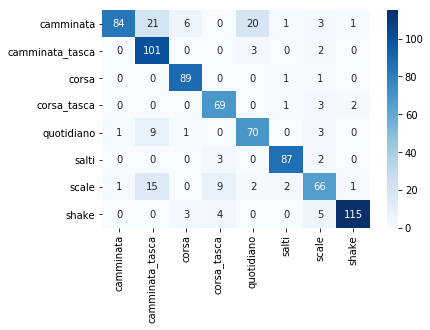

In [87]:
qda = QuadraticDiscriminantAnalysis(priors=weights)
qda.fit(X_train, y_train)
y_pred_qda = qda.predict(X_val)
acc_qda = 100*accuracy_score(y_val, y_pred_qda)
print("Accuratezza QDA: {:.1f}%".format(acc_qda))
MatriceConfusione(y_val, y_pred_qda)

## Alberi di regressione

Accuratezza DecisionTreeClassifier(): 85.38%


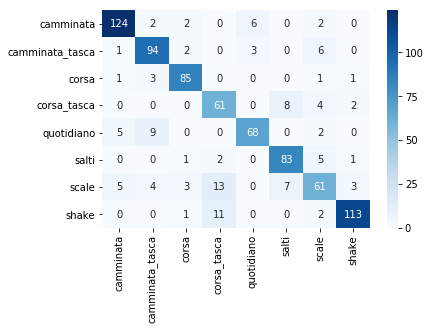

In [88]:
# Albero stimato sul training, senza vincoli (albero completo)
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_val)
acc_dtcFull = accuracy_score(y_val, y_pred)

print("Accuratezza DecisionTreeClassifier(): {:.2f}%".format(100 * acc_dtcFull))
MatriceConfusione(y_val, y_pred)
plt.show()

In [89]:
maxDepth = dtc.tree_.max_depth
minObs = len(X_train) // 2
print("Profondità dell'albero allenato senza restrizioni: {}".format(maxDepth))
print("Massimo numero minimo di osservazioni in una foglia: {}".format(minObs))

Profondità dell'albero allenato senza restrizioni: 18
Massimo numero minimo di osservazioni in una foglia: 1209


In [90]:
param_grid = ParameterGrid({
    'max_depth': np.arange(1, dtc.tree_.max_depth),
    'min_samples_leaf': 2 ** np.arange(int(np.log2(minObs) + 1)),
})
print(param_grid.param_grid)

[{'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]), 'min_samples_leaf': array([   1,    2,    4,    8,   16,   32,   64,  128,  256,  512, 1024])}]


In [91]:
risultati = []

for params in tqdm.tqdm(param_grid):
    dtc = DecisionTreeClassifier(random_state=42, **params)
    dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_val)
    params["accuracy_score"] = accuracy_score(y_val, y_pred)
    risultati.append(params)

risultati = pd.DataFrame(risultati).sort_values(["accuracy_score", "max_depth"], ascending=[False, True])
risultati.reset_index(drop=True, inplace=True)
print("Primi 5:")
display(risultati.head())

print("Ultimi 5:")
risultati.tail()

100%|██████████| 187/187 [00:01<00:00, 140.17it/s]

Primi 5:


,accuracy_score,max_depth,min_samples_leaf
0,0.851301,17,1
1,0.847584,16,1
2,0.846344,11,1
3,0.845105,15,1
4,0.842627,11,8


Ultimi 5:


,accuracy_score,max_depth,min_samples_leaf
182,0.28005,13,1024
183,0.28005,14,1024
184,0.28005,15,1024
185,0.28005,16,1024
186,0.28005,17,1024


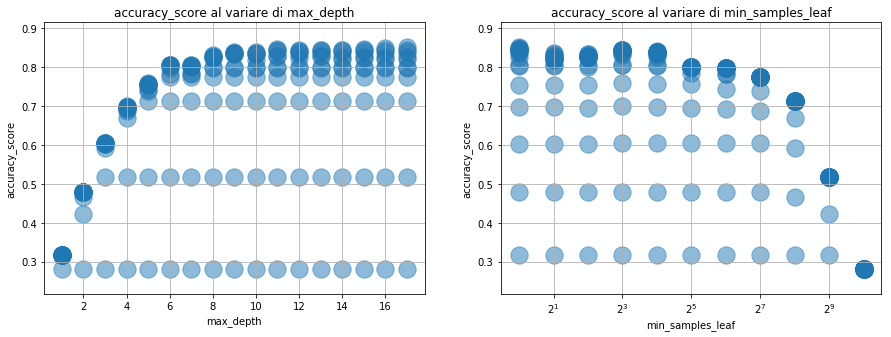

In [92]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
grafico_metrica_iperparametro(risultati, "max_depth", "accuracy_score", alpha=0.5)

plt.subplot(122)
grafico_metrica_iperparametro(risultati, "min_samples_leaf", "accuracy_score", alpha=0.5)
plt.xscale("log", basex=2)

plt.show()

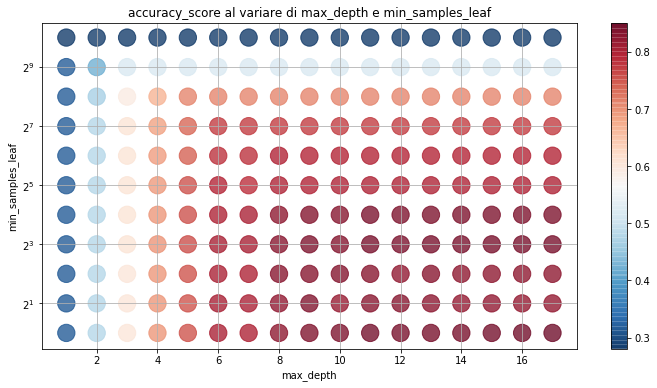

In [93]:
plt.figure(figsize=(12, 6))

grafico_metrica_iperparametri(risultati, "max_depth", "min_samples_leaf", "accuracy_score")
plt.yscale("log", basey=2)
plt.savefig(FIG_PATH + "iperparametri-Tree.png", dpi=200)
plt.show()

In [94]:
max_depth = risultati.loc[0, "max_depth"]
min_samples_leaf = risultati.loc[0, "min_samples_leaf"]

dtcTun = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
dtcTun.fit(X_train, y_train)

y_pred = dtcTun.predict(X_val)
acc_dtcTun = accuracy_score(y_val, y_pred)
print("profondità ottimale:",max_depth)
print("numero ottimale minimo di unità per foglia:",min_samples_leaf)

profondità ottimale: 17
numero ottimale minimo di unità per foglia: 1


Accuratezza DecisionTreeClassifier(): 85.4%
Accuratezza DecisionTreeClassifier(max_depth=17, min_samples_leaf=1): 85.1%
[[124   2   2   0   6   0   2   0]
 [  1  94   2   0   3   0   6   0]
 [  1   3  85   0   0   0   1   1]
 [  0   0   0  58   0   9   6   2]
 [  5   9   0   0  68   0   2   0]
 [  0   0   1   2   0  83   5   1]
 [  5   4   3  14   0   7  60   3]
 [  0   0   1   9   0   0   2 115]]


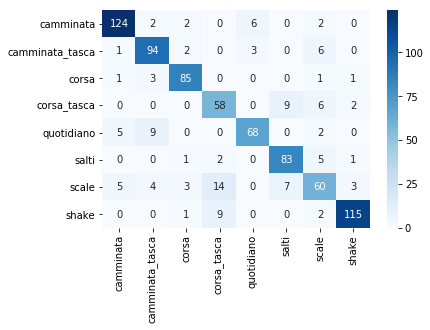

<Figure size 432x288 with 0 Axes>

In [99]:
print("Accuratezza DecisionTreeClassifier(): {:.1f}%".format(100 * dtc_acc))
print("Accuratezza DecisionTreeClassifier(max_depth={}, min_samples_leaf={}): {:.1f}%".format(
    max_depth, min_samples_leaf, 100 * acc_dtcTun))
print(confusion_matrix(y_val, y_pred))

MatriceConfusione(y_val, y_pred)
plt.savefig(FIG_PATH + "confusionMatrix-Tree.png", dpi=300, bbox_inches="tight")
plt.show()

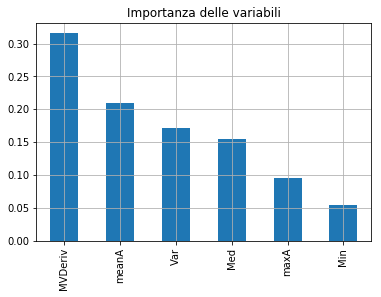

In [98]:
importanze = dtcTun.feature_importances_
variabili = espl.columns

grafico_importanza_variabili(importanze, variabili)
plt.savefig(FIG_PATH + "importance-Tree.png", dpi=300, bbox_inches="tight")
plt.show()